# Timeseries anomaly detection using an Autoencoder

## Introduction

This script demonstrates how you can use a reconstruction convolutional autoencoder model to detect anomalies in timeseries data.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchsummary import summary
from matplotlib import pyplot as plt
import sys

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

Nvidia cuDNN은 convolution (CNN)을 계산하기 위해 다양한 알고리즘을 지원

Autotuner는 짧은 benchmark 실행하고, 하드웨어와 input 크기에 최적화된 알고리즘을 선택

(주의) 고정된 input 크기일 때만 효과적이고, input 크기가 동적으로 변하면 매번 최적화된 알고리즘을 찾게 되어 시간이 더 오래 걸릴 수도 있다.

(출처 : https://medium.com/naver-shopping-dev/top-10-performance-tuning-practices-for-pytorch-e6c510152f76)

## Load the data

We will use the Numenta Anomaly Benchmark(NAB) dataset. 

It provides artifical timeseries data containing labeled anomalous periods of behavior. 

Data are ordered, timestamped, single-valued metrics.

We will use the art_daily_small_noise.csv file for training and the art_daily_jumpsup.

csv file for testing. 

The simplicity of this dataset allows us to demonstrate anomaly detection effectively.

In [3]:
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

## Quick look at the data

In [4]:
print(df_small_noise.head())
print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


## Visualize the data

### Timeseries data without anomalies

We will use the following data for training.

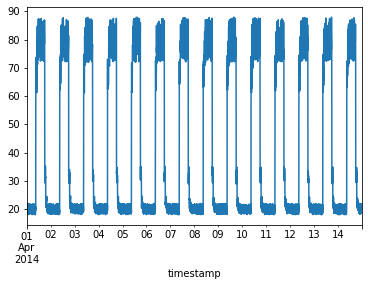

In [5]:
fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

### Timeseries data with anomalies
We will use the following data for testing and see if the sudden jump up in the data is detected as an anomaly.

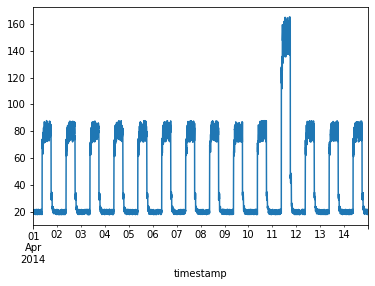

In [6]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the value data. We have a value for every 5 mins for 14 days.

24 * 60 / 5 = 288 timesteps per day

288 * 14 = 4032 data points in total

In [7]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create sequences
Create sequences combining TIME_STEPS contiguous data values from the training data.

In [8]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x = create_sequences(df_training_value.values)
print("Training input shape: ", x.shape)

Training input shape:  (3744, 288, 1)


<img src='../img/time.png' width='600'>

In [97]:
params = {'batch_size': 128,
          'shuffle': True,
          'num_workers': 8,
#          'collate_fn' : lambda x: default_collate(x).to(device),
         'pin_memory' : True}

val_rate = 0.1

x_train = x[:int(len(x)*(1-val_rate))]
x_val = x[int(len(x)*(1-val_rate)):]

x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 2, 1)
x_val = torch.tensor(x_val, dtype=torch.float32).permute(0, 2, 1).to(device)

dataloader = DataLoader(x_train, **params)

- collate_fn

사용자 정의 함수에 따른 데이터셋을 만들어주는데 사용

- num_workers

여러 프로세스를 사용하여 디스크에서 데이터를 비동기식으로 읽고, 학습과 데이터로딩이 overlapping될 수 있도록 허용. 

CPU의 데이터 로딩을 빠르게 처리하는 용도로 사용.

- pin_memory

데이터 텐서를 자동으로 pinned 메모리로 가져오기 때문에, 데이터 전송이 빠릅니다.

<img src='https://miro.medium.com/max/700/1*HxXxttwZ4z_9PEv8ArS8eA.png' width='600'>

(출처 : https://medium.com/naver-shopping-dev/top-10-performance-tuning-practices-for-pytorch-e6c510152f76)

## Build a model
We will build a convolutional reconstruction autoencoder model. 

The model will take input of shape (batch_size, sequence_length, num_features) and return output of the same shape. 

In this case, sequence_length is 288 and num_features is 1.

In [10]:
class anomaly_detecter(nn.Module):
    def __init__(self, input_channel, kernel_size=7, stride=2):
        super(anomaly_detecter, self).__init__()
        
        self.ad_layer = nn.Sequential(
            nn.Conv1d(input_channel, 32, kernel_size, stride=stride, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv1d(32, 16, kernel_size, stride=stride, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 16, kernel_size, stride=stride, padding=3, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.ConvTranspose1d(16, 32, kernel_size, stride=stride, padding=3, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, 1, kernel_size, padding=3),
        )
        
    def forward(self, inputs):
        output = self.ad_layer(inputs)
        return output

In [101]:
model = anomaly_detecter(x_train.shape[1]).to(device)
summary(model, (1, 288))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 144]             256
              ReLU-2              [-1, 32, 144]               0
           Dropout-3              [-1, 32, 144]               0
            Conv1d-4               [-1, 16, 72]           3,600
              ReLU-5               [-1, 16, 72]               0
   ConvTranspose1d-6              [-1, 16, 144]           1,808
              ReLU-7              [-1, 16, 144]               0
           Dropout-8              [-1, 16, 144]               0
   ConvTranspose1d-9              [-1, 32, 288]           3,616
             ReLU-10              [-1, 32, 288]               0
  ConvTranspose1d-11               [-1, 1, 288]             225
Total params: 9,505
Trainable params: 9,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

In [102]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [13]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, batch in enumerate(train_data):
        
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
                
        input = batch.to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, input)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss/len(train_data)

- Efficiently zero-out gradients

모든 파라미터마다 memset을 실행하지 않습니다.

Gradient를 업데이트할 때, “+=” (read+write)이 아닌 “=” (write)를 사용합니다.

Pytorch 백엔드에서 더 효율적으로 gradient을 0으로 만듭니다 (zero out).

- Use 16-bit precision

FP32으로만 학습할 때와 비슷한 정확도.

필요한 메모리 사이즈 감소.

학습 시간 감소.

(출처 : https://medium.com/naver-shopping-dev/top-10-performance-tuning-practices-for-pytorch-e6c510152f76)

In [14]:
def validation(model, val_data, loss_fn):
    model.eval()
    
    with torch.no_grad():
        predictions = model.forward(val_data)
        val_loss = loss_fn(predictions, val_data)
        
    return val_loss.item()/len(val_data)

In [15]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [103]:
%%time
%%prun
epochs = 1000
history = dict()
early_stopping = EarlyStopping(patience=20, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss = train(model, dataloader, optimizer, loss_fn, use_fp16=True)
    val_loss = validation(model, x_val, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    
    sys.stdout.write(
        "\r" + f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Validation Loss: {val_loss:.4}"\
                    )
    
    if early_stopping.validate(val_loss):
        break

[Train] Epoch : 78   Train Loss: 0.004646  Validation Loss: 1.912e-05
 Training process is stopped early....
 CPU times: user 10.9 s, sys: 24.9 s, total: 35.8 s
Wall time: 37.5 s


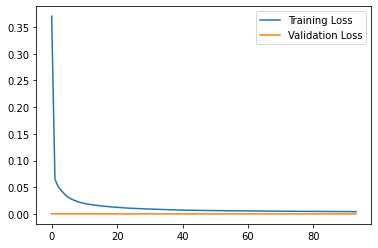

In [17]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [18]:
# Get train MAE loss.
model.eval()
x_train_pred = model(x_train.to(device)).clone().detach().cpu()
loss_fn = nn.MSELoss(reduction='none')
train_mae_loss = loss_fn(x_train_pred, x_train).squeeze(1).numpy()
train_mae_loss = np.mean(train_mae_loss, axis=1)

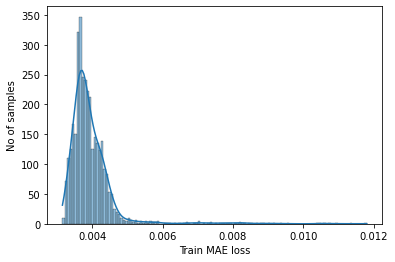

Reconstruction error threshold:  0.011801764


In [19]:
import seaborn as sns

sns.histplot(train_mae_loss, kde=True)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

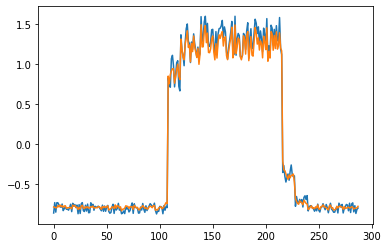

In [20]:
# Checking how the first sequence is learnt
plt.plot(x_train[0][0])
plt.plot(x_train_pred[0][0])
plt.show()

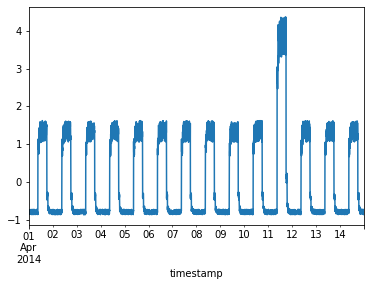

Test input shape:  torch.Size([3744, 1, 288])


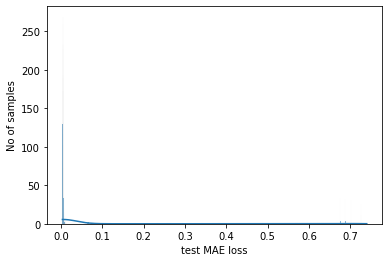

Number of anomaly samples:  397
Indices of anomaly samples:  (array([2521, 2522, 2701, 2702, 2703, 2704, 2705, 2706, 2707, 2708, 2709,
       2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720,
       2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731,
       2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742,
       2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753,
       2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764,
       2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775,
       2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786,
       2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797,
       2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808,
       2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819,
       2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830,
       2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839, 2

In [21]:
df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 2, 1)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model(x_test.to(device)).clone().detach().cpu()

test_mae_loss = loss_fn(x_test_pred, x_test).squeeze(1).numpy()
test_mae_loss = np.mean(test_mae_loss, axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

# print(test_mae_loss)

# plt.hist(test_mae_loss, bins=50)
sns.histplot(test_mae_loss, kde=True)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [22]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

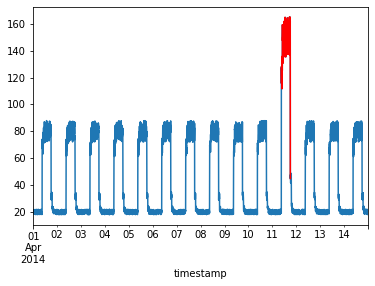

In [23]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

---

In [39]:
def main():

    epochs = 1000
    history = dict()
    early_stopping = EarlyStopping(patience=20, verbose=1)
    for epoch in range(1, epochs+1):
        epoch_loss = train(model, dataloader, optimizer, loss_fn, use_fp16=True)
        val_loss = validation(model, x_val, loss_fn)

        history.setdefault('loss', []).append(epoch_loss) 
        history.setdefault('val_loss', []).append(val_loss) 

        sys.stdout.write(
            "\r" + f"[Train] Epoch : {epoch:^3}"\
            f"  Train Loss: {epoch_loss:.4}"\
            f"  Validation Loss: {val_loss:.4}"\
                        )

        if early_stopping.validate(val_loss):
            break

# Profiler

## cProfile

In [ ]:
!python -m cProfile -o profile.stats Timeseries_anomaly_detection_using_an_Autoencoder.py

In [47]:
import pstats
p = pstats.Stats("profile.stats")
p.sort_stats("cumulative")
p.print_stats()

Sun May 23 17:22:06 2021    profile.stats

         2718783 function calls (2679634 primitive calls) in 23.293 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   1235/1    0.021    0.000   23.295   23.295 {built-in method builtins.exec}
        1    0.005    0.005   23.295   23.295 Timeseries_anomaly_detection_using_an_Autoencoder.py:1(<module>)
       50    0.078    0.002   17.292    0.346 Timeseries_anomaly_detection_using_an_Autoencoder.py:45(train)
       50    0.000    0.000    8.852    0.177 /usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py:342(__iter__)
       50    0.002    0.000    8.852    0.177 /usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py:296(_get_iterator)
       50    0.033    0.001    8.849    0.177 /usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py:873(__init__)
      400    0.015    0.000    8.033    0.020 /usr/lib/python3.6/multiprocessing/pr

        1    0.000    0.000    0.013    0.013 /usr/local/lib/python3.6/dist-packages/mpl_toolkits/mplot3d/axes3d.py:11(<module>)
      200    0.001    0.000    0.013    0.000 /usr/lib/python3.6/multiprocessing/context.py:79(Semaphore)
        1    0.000    0.000    0.013    0.013 /usr/local/lib/python3.6/dist-packages/pandas/core/arrays/interval.py:1(<module>)
        2    0.012    0.006    0.013    0.006 {method 'read' of 'pandas._libs.parsers.TextReader' objects}
      137    0.000    0.000    0.013    0.000 /usr/lib/python3.6/typing.py:843(__getitem__)
  451/408    0.001    0.000    0.013    0.000 /usr/lib/python3.6/typing.py:805(_subs_tree)
        1    0.000    0.000    0.012    0.012 /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/api.py:1(<module>)
        1    0.000    0.000    0.012    0.012 /usr/local/lib/python3.6/dist-packages/pandas/core/window/__init__.py:1(<module>)
      746    0.012    0.000    0.012    0.000 {method 'sub' of '_sre.SRE_Pattern' objects}
    

        1    0.000    0.000    0.003    0.003 /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/datetimelike.py:3(<module>)
        1    0.000    0.000    0.003    0.003 /usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1(<module>)
        1    0.000    0.000    0.003    0.003 /usr/local/lib/python3.6/dist-packages/pandas/io/json/__init__.py:1(<module>)
        1    0.000    0.000    0.003    0.003 /usr/local/lib/python3.6/dist-packages/pandas/core/series.py:139(Series)
       56    0.000    0.000    0.003    0.000 /usr/local/lib/python3.6/dist-packages/pyparsing.py:3901(<listcomp>)
      400    0.001    0.000    0.003    0.000 /usr/lib/python3.6/selectors.py:233(register)
        3    0.000    0.000    0.003    0.001 /usr/local/lib/python3.6/dist-packages/matplotlib/patches.py:1867(pprint_styles)
        1    0.000    0.000    0.002    0.002 /usr/local/lib/python3.6/dist-packages/torch/serialization.py:1(<module>)
        2    0.000    0.000    0.002    0.001 

        1    0.000    0.000    0.001    0.001 /usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:237(ModuleDict)
        1    0.000    0.000    0.001    0.001 /usr/local/lib/python3.6/dist-packages/PIL/TiffTags.py:20(<module>)
       12    0.000    0.000    0.001    0.000 /usr/lib/python3.6/enum.py:760(_missing_)
     1350    0.001    0.000    0.001    0.000 /usr/local/lib/python3.6/dist-packages/torch/autograd/__init__.py:60(_tensor_or_tensors_to_tuple)
        1    0.000    0.000    0.001    0.001 /usr/local/lib/python3.6/dist-packages/torch/_tensor_docs.py:1(<module>)
        6    0.000    0.000    0.001    0.000 /usr/local/lib/python3.6/dist-packages/numpy/core/getlimits.py:35(__init__)
      344    0.001    0.000    0.001    0.000 /usr/lib/python3.6/sre_parse.py:342(_escape)
        1    0.000    0.000    0.001    0.001 /usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:10(<module>)
     1156    0.001    0.000    0.001    0.000 /usr/lib/python3.6/sre_p

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/arrays/string_.py:25(StringDtype)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/numpy/core/_exceptions.py:7(<module>)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/groupby/generic.py:858(DataFrameGroupBy)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/arrays/numpy_.py:124(PandasArray)
       12    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/nanops.py:53(__init__)
       21    0.000    0.000    0.000    0.000 /usr/lib/python3.6/pathlib.py:998(__new__)
      127    0.000    0.000    0.000    0.000 /usr/lib/python3.6/codecs.py:318(decode)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/dtypes.py:44(PandasExtensionDtype)
       83    0.000    0.000    0.000    0.

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/io/formats/format.py:1282(FloatArrayFormatter)
       16    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:2009(_noarg_wrapper)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/arrays/sparse/array.py:1486(_add_comparison_ops)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/accessor.py:13(DirNamesMixin)
       26    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/common.py:696(is_integer_dtype)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/arrays/integer.py:39(_IntegerDtype)
       16    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/ops/__init__.py:327(_arith_method_SERIES)
       51    0.000    0.000    0.000    0.000 /usr/

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/io/spss.py:1(<module>)
        2    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:1639(_maybe_dedup_names)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/groupby/grouper.py:388(Grouping)
       12    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/series.py:398(_set_axis)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/arrays/_mixins.py:1(<module>)
        5    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/nanops.py:322(_na_ok_dtype)
        6    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/dtypes/cast.py:1187(maybe_castable)
       35    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/numpy/core/_dtype.py:307(_name_i

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/gridspec.py:602(SubplotSpec)
        4    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:562(_set_axis)
        4    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:2000(inferred_type)
        7    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py:2007(is_all_dates)
        4    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/ops/methods.py:24(_get_method_wrappers)
       10    0.000    0.000    0.000    0.000 /usr/lib/python3.6/tokenize.py:379(read_or_stop)
       94    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:2038(IdentityTransform)
      141    0.000    0.000    0.000  

       18    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/transforms.py:52(_make_str_method)
       85    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/cycler.py:138(keys)
      130    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/cycler.py:212(<genexpr>)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/distributions/continuous_bernoulli.py:11(ContinuousBernoulli)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/distributions/geometric.py:10(Geometric)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/uu.py:31(<module>)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/ssl.py:376(Purpose)
       72    0.000    0.000    0.000    0.000 /usr/lib/python3.6/ipaddress.py:417(_check_int_address)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/optim/_

        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/streams.py:271(StreamWriter)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/ipaddress.py:1049(_BaseV4)
       94    0.000    0.000    0.000    0.000 /usr/lib/python3.6/ipaddress.py:550(__int__)
        2    0.000    0.000    0.000    0.000 /usr/lib/python3.6/email/feedparser.py:197(_new_message)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/jit/_trace.py:1086(_script_if_tracing)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/nn/modules/transformer.py:16(Transformer)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/nn/modules/sparse.py:12(Embedding)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/nn/modules/activation.py:831(MultiheadAttention)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-package

        3    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/distributed/__init__.py:6(is_available)
       11    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:951(remove_from)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/io/json/_json.py:625(JsonReader)
        8    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:1235(_is_index_col)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/api/indexers/__init__.py:3(<module>)
        1    0.000    0.000    0.000    0.000 <string>:5(NamedAgg)
        2    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5242(<lambda>)
        8    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/pandas/core/internals/managers.py:326(<genexpr>)
        2    0.000    0.000    0.000

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/offsetbox.py:918(AuxTransformBox)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/offsetbox.py:1007(AnchoredOffsetbox)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/widgets.py:2443(PolygonSelector)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/backend_bases.py:3282(ToolContainerBase)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/backend_bases.py:3460(_Backend)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/backend_tools.py:504(ToolYScale)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/backend_tools.py:694(ToolHome)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/ma

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/distributions/constraints.py:321(_GreaterThanEq)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/streams.py:25(IncompleteReadError)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/streams.py:220(StreamReaderProtocol)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/subprocess.py:18(SubprocessStreamProtocol)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/transports.py:10(BaseTransport)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/transports.py:178(SubprocessTransport)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/transports.py:230(_FlowControlMixin)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/unix_events.py:843(SafeChildWatcher)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/asyncio/tasks.py:540(_Ga

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/PIL/TiffTags.py:23(TagInfo)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/PIL/_util.py:25(deferred_error)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/PIL/Image.py:3053(register_mime)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/PIL/Image.py:3064(register_save)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/PIL/Image.py:3075(register_save_all)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/xml/__init__.py:17(<module>)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/xml/etree/ElementTree.py:104(ParseError)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/matplotlib/mathtext.py:212(MathtextBackendBitmap)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-p

        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/distributed/autograd/__init__.py:28(context)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/typing_extensions.py:772(_ExtensionsGenericMeta)
        5    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/typing_extensions.py:1171(<genexpr>)
        4    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/typing_extensions.py:1172(<genexpr>)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/typing_extensions.py:1658(_TypedDictMeta)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/utils/_pytree.py:95(LeafSpec)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/autograd/grad_mode.py:84(no_grad)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/torch/autograd/grad_mode.py:

        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/shutil.py:65(ExecError)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/shutil.py:71(RegistryError)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/copyreg.py:22(constructor)
        6    0.000    0.000    0.000    0.000 /usr/lib/python3.6/sre_parse.py:161(__delitem__)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/sre_parse.py:287(seek)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/contextlib.py:36(_recreate_cm)
        1    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap_external>:966(_find_parent_path_names)
        1    0.000    0.000    0.000    0.000 {method 'isdisjoint' of 'set' objects}
        2    0.000    0.000    0.000    0.000 {method 'rfind' of 'bytes' objects}
        1    0.000    0.000    0.000    0.000 {built-in method time.tim

        2    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/six.py:189(__get_module)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/six.py:324(Module_six_moves_urllib_parse)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/six.py:366(Module_six_moves_urllib_error)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/six.py:386(Module_six_moves_urllib_request)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/six.py:438(Module_six_moves_urllib_response)
        1    0.000    0.000    0.000    0.000 /usr/local/lib/python3.6/dist-packages/six.py:459(Module_six_moves_urllib_robotparser)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/distutils/version.py:323(__str__)
        1    0.000    0.000    0.000    0.000 /usr/lib/python3.6/typing.py:428(_NoReturn)
        1    0.000    0.000    0.000    0.000 /usr/lib/

## line Proflier

pip install line_profiler

In [52]:
!kernprof -l -v Timeseries_anomaly_detection_using_an_Autoencoder.py

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 144]             256
              ReLU-2              [-1, 32, 144]               0
           Dropout-3              [-1, 32, 144]               0
            Conv1d-4               [-1, 16, 72]           3,600
              ReLU-5               [-1, 16, 72]               0
   ConvTranspose1d-6              [-1, 16, 144]           1,808
              ReLU-7              [-1, 16, 144]               0
           Dropout-8              [-1, 16, 144]               0
   ConvTranspose1d-9              [-1, 32, 288]           3,616
             ReLU-10              [-1, 32, 288]               0
  ConvTranspose1d-11               [-1, 1, 288]             225
Total params: 9,505
Trainable params: 9,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

## memory Profiler

pip install memory_profiler

In [53]:
!python -m memory_profiler Timeseries_anomaly_detection_using_an_Autoencoder.py

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 144]             256
              ReLU-2              [-1, 32, 144]               0
           Dropout-3              [-1, 32, 144]               0
            Conv1d-4               [-1, 16, 72]           3,600
              ReLU-5               [-1, 16, 72]               0
   ConvTranspose1d-6              [-1, 16, 144]           1,808
              ReLU-7              [-1, 16, 144]               0
           Dropout-8              [-1, 16, 144]               0
   ConvTranspose1d-9              [-1, 32, 288]           3,616
             ReLU-10              [-1, 32, 288]               0
  ConvTranspose1d-11               [-1, 1, 288]             225
Total params: 9,505
Trainable params: 9,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

Contents는 원본 코드

Mem Usage는 현재 메모리 사용량

Increment는 해당 줄이 얼마나 memory를 증가시켰는지

# Comparison

## time

apt install time

### collate_fn : False / pin_memory :  True / workers : 0 / fp16 : False

In [73]:
!/usr/bin/time -p python Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C False -W 0 -E False -F False

[Train] Epoch : 1000  Train Loss: 0.001002  Validation Loss: 1.031e-05real 80.52
user 304.39
sys 2.16


### collate_fn : True / pin_memory :  False / workers : 0 / fp16 : False

In [74]:
!/usr/bin/time -p python Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C True -W 0 -E False -F False

[Train] Epoch : 1000  Train Loss: 0.000949  Validation Loss: 9.607e-06real 79.85
user 77.61
sys 1.84


### collate_fn : False / pin_memory :  True / workers : 4 / fp16 : False

In [69]:
!/usr/bin/time -p python Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C False -W 4 -E False -F False

[Train] Epoch : 1000  Train Loss: 0.000914  Validation Loss: 1.302e-05real 209.12
user 121.49
sys 249.57


### collate_fn : False / pin_memory :  True / workers : 4 / fp16 : True

In [70]:
!/usr/bin/time -p python Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C False -W 4 -E False -F False

[Train] Epoch : 1000  Train Loss: 0.0009606  Validation Loss: 1.693e-05real 209.48
user 121.02
sys 250.56


### collate_fn : False / pin_memory :  True / workers : 0 / fp16 : True

In [71]:
!/usr/bin/time -p python Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C False -W 0 -E False -F True

[Train] Epoch : 1000  Train Loss: 0.0009166  Validation Loss: 7.996e-06real 116.34
user 444.88
sys 2.42


### collate_fn : True / pin_memory :  False / workers : 0 / fp16 : True

In [72]:
!/usr/bin/time -p python Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C True -W 0 -E False -F True

[Train] Epoch : 1000  Train Loss: 0.0009448  Validation Loss: 7.007e-06real 105.75
user 104.11
sys 1.97


## memory

### collate_fn : False / pin_memory :  True / workers : 0 / fp16 : False

In [76]:
!python -m memory_profiler Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C False -W 0 -E False -F False

[Train] Epoch : 1000  Train Loss: 0.0009332  Validation Loss: 6.563e-06Filename: Timeseries_anomaly_detection_using_an_Autoencoder.py

Line #    Mem usage    Increment  Occurences   Line Contents
   118 1047.801 MiB 1047.801 MiB           1   @profile    
   119                                         def main(use_summary: bool=False, use_collate: bool=False, 
   120                                                  num_workers: int=0, use_early_stopping: bool=True, use_fp16: bool=True):
   121                                             
   122 1047.801 MiB    0.000 MiB           1       master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
   123                                         
   124 1047.801 MiB    0.000 MiB           1       df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
   125 1047.801 MiB    0.000 MiB           1       df_small_noise_url = master_url_root + df_small_noise_url_suffix
   126 1047.801 MiB    0.000 MiB   

### collate_fn : True / pin_memory :  False / workers : 0 / fp16 : False

In [81]:
!python -m memory_profiler Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C True -W 0 -E False -F False

[Train] Epoch : 1000  Train Loss: 0.000873  Validation Loss: 9.351e-06Filename: Timeseries_anomaly_detection_using_an_Autoencoder.py

Line #    Mem usage    Increment  Occurences   Line Contents
   118 1047.934 MiB 1047.934 MiB           1   @profile    
   119                                         def main(use_summary: bool=False, use_collate: bool=False, 
   120                                                  num_workers: int=0, use_early_stopping: bool=True, use_fp16: bool=True):
   121                                             
   122 1047.934 MiB    0.000 MiB           1       master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
   123                                         
   124 1047.934 MiB    0.000 MiB           1       df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
   125 1047.934 MiB    0.000 MiB           1       df_small_noise_url = master_url_root + df_small_noise_url_suffix
   126 1047.934 MiB    0.000 MiB    

### collate_fn : False / pin_memory :  True / workers : 0 / fp16 : True

In [80]:
!python -m memory_profiler Timeseries_anomaly_detection_using_an_Autoencoder.py -S False -C False -W 0 -E False -F True

[Train] Epoch : 1000  Train Loss: 0.4575  Validation Loss: 0.001134Filename: Timeseries_anomaly_detection_using_an_Autoencoder.py

Line #    Mem usage    Increment  Occurences   Line Contents
   118 1047.762 MiB 1047.762 MiB           1   @profile    
   119                                         def main(use_summary: bool=False, use_collate: bool=False, 
   120                                                  num_workers: int=0, use_early_stopping: bool=True, use_fp16: bool=True):
   121                                             
   122 1047.762 MiB    0.000 MiB           1       master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"
   123                                         
   124 1047.762 MiB    0.000 MiB           1       df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
   125 1047.762 MiB    0.000 MiB           1       df_small_noise_url = master_url_root + df_small_noise_url_suffix
   126 1047.762 MiB    0.000 MiB       

# pytorch_memlab

pip install pytorch_memlab

In [83]:
%load_ext pytorch_memlab

In [88]:
def main(use_fp16=True):

    epochs = 1000
    history = dict()
    early_stopping = EarlyStopping(patience=20, verbose=1)
    for epoch in range(1, epochs+1):
        epoch_loss = train(model, dataloader, optimizer, loss_fn, use_fp16=use_fp16)
        val_loss = validation(model, x_val, loss_fn)

        history.setdefault('loss', []).append(epoch_loss) 
        history.setdefault('val_loss', []).append(val_loss) 

        sys.stdout.write(
            "\r" + f"[Train] Epoch : {epoch:^3}"\
            f"  Train Loss: {epoch_loss:.4}"\
            f"  Validation Loss: {val_loss:.4}"\
                        )

        if early_stopping.validate(val_loss):
            break

In [93]:
from pytorch_memlab import MemReporter
reporter = MemReporter(model)
reporter.report()
main(use_fp16=True)

Element type                                            Size  Used MEM
-------------------------------------------------------------------------------
Storage on cpu
Tensor0                                       (3369, 1, 288)     3.70M
Tensor1                                       (3744, 1, 288)     4.11M
Tensor2                                       (3744, 1, 288)     4.11M
Tensor3                                       (3369, 1, 288)     3.70M
-------------------------------------------------------------------------------
Total Tensors: 4097088 	Used Memory: 15.63M
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Storage on cuda:0
Tensor4                                        (375, 1, 288)   422.00K
ad_layer.10.bias                                        (1,)   512.00B
ad_layer.10.bias.grad                                   (1,)   512.00B
ad_layer.10.weight                 

---